In [1]:
from pathlib import Path
from typing import Callable, Mapping

import matplotlib.pyplot as plt
import numpy as np
import ood_metrics
import pandas as pd
import seaborn as sns
from matplotlib.axes._axes import Axes
from sklearn.base import ClassifierMixin, OutlierMixin, clone
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [2]:
data_path = Path("data/")

In [3]:
def train_test_with_class_holdout(X_train: np.ndarray[float],
                                  y_train: np.ndarray[int],
                                  X_test: np.ndarray[float],
                                  y_test: np.ndarray[int],
                                  classifier: ClassifierMixin,
                                  scorer: OutlierMixin) -> pd.DataFrame:
    """For each class trains a model holding out that class.

    Args:
      X_train: Array of shape (n_samples, n_features).
      y_train: Array of shape (n_samples,).

    Returns:
      A dataframe with the held-out class, trained classifier and scorer.
    """
    models = []
    labels = np.sort(np.unique(y_train))
    for label in tqdm(labels):
        label_mask = y_train != label
        holdout_classifier = clone(classifier)
        holdout_classifier.fit(X_train[label_mask, :], y_train[label_mask])
        holdout_scorer = clone(scorer)
        holdout_scorer.fit(X_train[label_mask, :])

        decision_true = np.ones(y_test.shape, dtype=int)
        decision_true[y_test == label] = -1

        models.append({
            "class": label,
            "scorer": holdout_scorer,
            "classifier": holdout_classifier,
            "scores": holdout_scorer.score_samples(X_test),
            "decision_pred": holdout_scorer.predict(X_test),
            "decision_true": decision_true,
            "y_pred": holdout_classifier.predict(X_test),
        })

    models = pd.DataFrame(models)
    return models

In [4]:
def multi_model_plot(models: pd.DataFrame,
                     plotter: Callable[[pd.Series, Axes], Axes],
                     plot_name: str = "",
                     data_name: str = "",
                     **kwargs) -> None:
    """Generates plots for multiple models.

    Args:
      models: Models trained for each class holdout.
      plotter: A function that generates a plot for a model on an axis.
    """
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 9))
    scorerer_name = type(models.loc[0, "scorer"]).__name__
    fig.suptitle(f'{plot_name}\nScorer: {scorerer_name}\nDataset: {data_name}')

    for i, row in models.iterrows():
        ax = axes.flatten()[i]
        plotter(row, ax, **kwargs)
        ax.title.set_text(row["class"])

    if len(axes.flatten()) != models.shape[0]:
        # Delete unused subplots.
        for i in range(-1, -(len(axes.flatten()) - models.shape[0] + 1), -1):
            fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

In [5]:
def plot_confusion_matrix(row: pd.Series | Mapping,
                          ax: Axes | None = None,
                          **kwargs) -> Axes:
    if not ax:
        ax = plt.gca()

    ConfusionMatrixDisplay.from_predictions(
        y_true=row["decision_true"],
        y_pred=row["decision_pred"],
        ax=ax,
        cmap="Blues",
    )
    return ax

In [6]:
def plot_scores(row: pd.Series | Mapping,
                ax: Axes | None = None,
                **kwargs) -> Axes:
    if not ax:
        ax = plt.gca()

    sns.ecdfplot(
        x=row["scores"],
        hue=np.where(row["decision_true"] == 1, "in", "out"),
        hue_order=["in", "out"],
        ax=ax,
    )
    ax.axvline(row["scorer"].offset_, color="black", linestyle=":", label="Threshold")
    if "xlim" in kwargs:
        ax.set_xlim(xlim)
    return ax

In [7]:
def plot_roc(row: pd.Series | Mapping,
             ax: Axes | None = None,
             **kwargs) -> Axes:
    """
    Adapted from plot_roc defined at
    https://github.com/tayden/ood-metrics/blob/main/ood_metrics/plots.py
    """
    if not ax:
        ax = plt.gca()

    fpr, tpr, _ = roc_curve(row["decision_true"], row["scores"])
    tpr95 = ood_metrics.fpr_at_95_tpr(row["scores"], row["decision_true"])
    roc_auc = ood_metrics.auroc(row["scores"], row["decision_true"])

    ax.plot(fpr, tpr, color="darkorange", label="AUROC = %0.2f" % roc_auc)
    ax.plot([0, 1], [0.95, 0.95],
            color="black",
            linestyle=":",
            label="FPR (95%% TPR) = %0.2f" % tpr95)
    ax.plot([tpr95, tpr95], [0, 1], color="black", linestyle=":")
    ax.plot([0, 1], [0, 1],
            color="navy",
            linestyle="--",
            label="Random detector ROC")
    ax.set(
        xlim=[0.0, 1.0],
        ylim=[0.0, 1.05],
        xlabel="FPR",
        ylabel="TPR",
    )
    ax.legend(loc="lower right")
    return ax

## MNIST

In [8]:
df = pd.read_parquet(data_path / "mnist" / "mnist.parquet")

In [9]:
df.columns

Index(['class', 'split', 'image', 'clip', 'clip_norm'], dtype='object')

In [10]:
train_mask = df["split"] == "train"
test_mask = df["split"] == "test"
X_train = np.array(df.loc[train_mask, "clip_norm"].tolist())
X_test = np.array(df.loc[test_mask, "clip_norm"].tolist())
y_train = df.loc[train_mask, "class"].to_numpy()
y_test = df.loc[test_mask, "class"].to_numpy()

In [11]:
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9641

In [12]:
scorer = LocalOutlierFactor(n_neighbors=15, novelty=True)
scorer.fit(X_train)
decision_pred = scorer.predict(X_test)
accuracy_score(np.ones(decision_pred.size), decision_pred)

0.9955

In [13]:
classifier = KNeighborsClassifier(n_neighbors=15)
scorer = LocalOutlierFactor(n_neighbors=15, novelty=True)
models = train_test_with_class_holdout(X_train, y_train, X_test, y_test,
                                       classifier, scorer)

100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


In [14]:
[accuracy_score(y_test, y_pred) for y_pred in models["y_pred"]]

[0.8689, 0.8532, 0.8685, 0.871, 0.871, 0.8823, 0.8744, 0.869, 0.8727, 0.8716]

In [15]:
[
    accuracy_score(true, pred)
    for true, pred in models[["decision_true", "decision_pred"]].values.tolist()
]

[0.912, 0.8944, 0.9003, 0.8956, 0.9109, 0.9125, 0.9065, 0.9148, 0.9033, 0.8993]

In [16]:
# FPR when TPR is at minimum 95%.
[
    np.round(ood_metrics.fpr_at_95_tpr(scores, labels), 3)
    for scores, labels in models[["scores", "decision_true"]].values.tolist()
]

[0.332, 0.263, 0.489, 0.678, 0.384, 0.61, 0.422, 0.365, 0.564, 0.568]

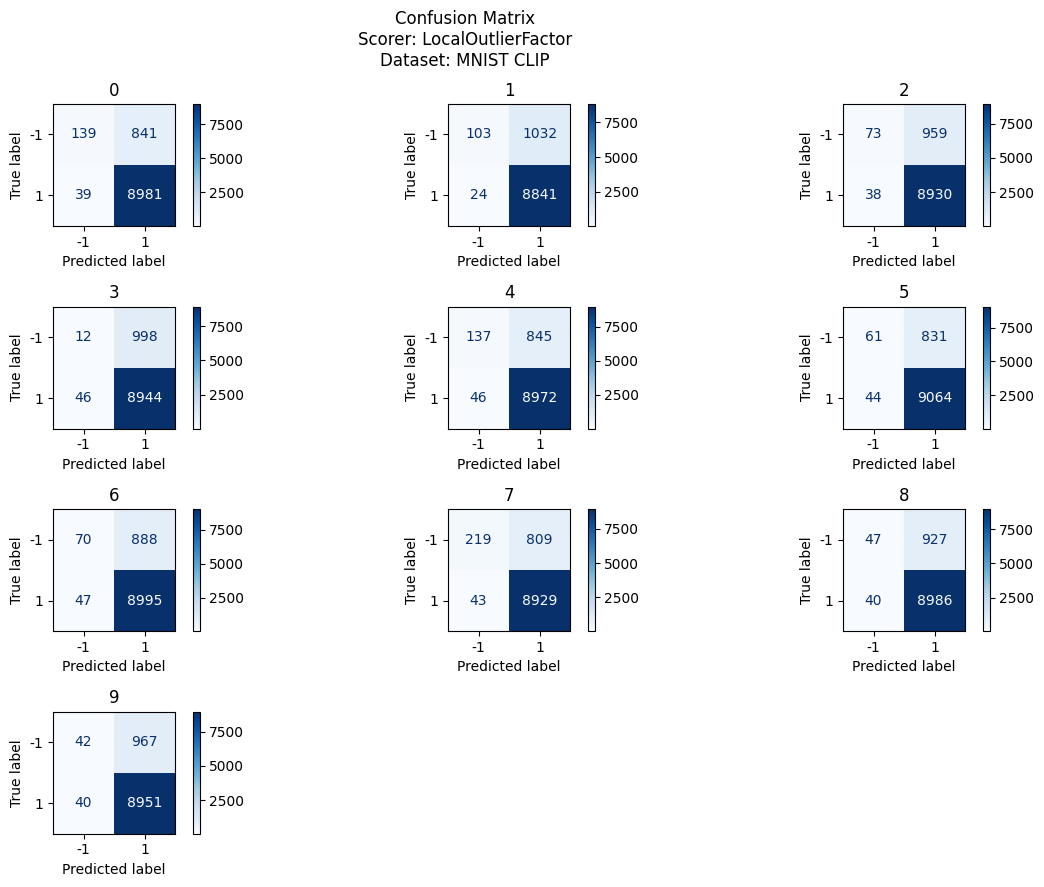

In [17]:
multi_model_plot(
    models,
    plot_confusion_matrix,
    plot_name="Confusion Matrix",
    data_name="MNIST CLIP",
)

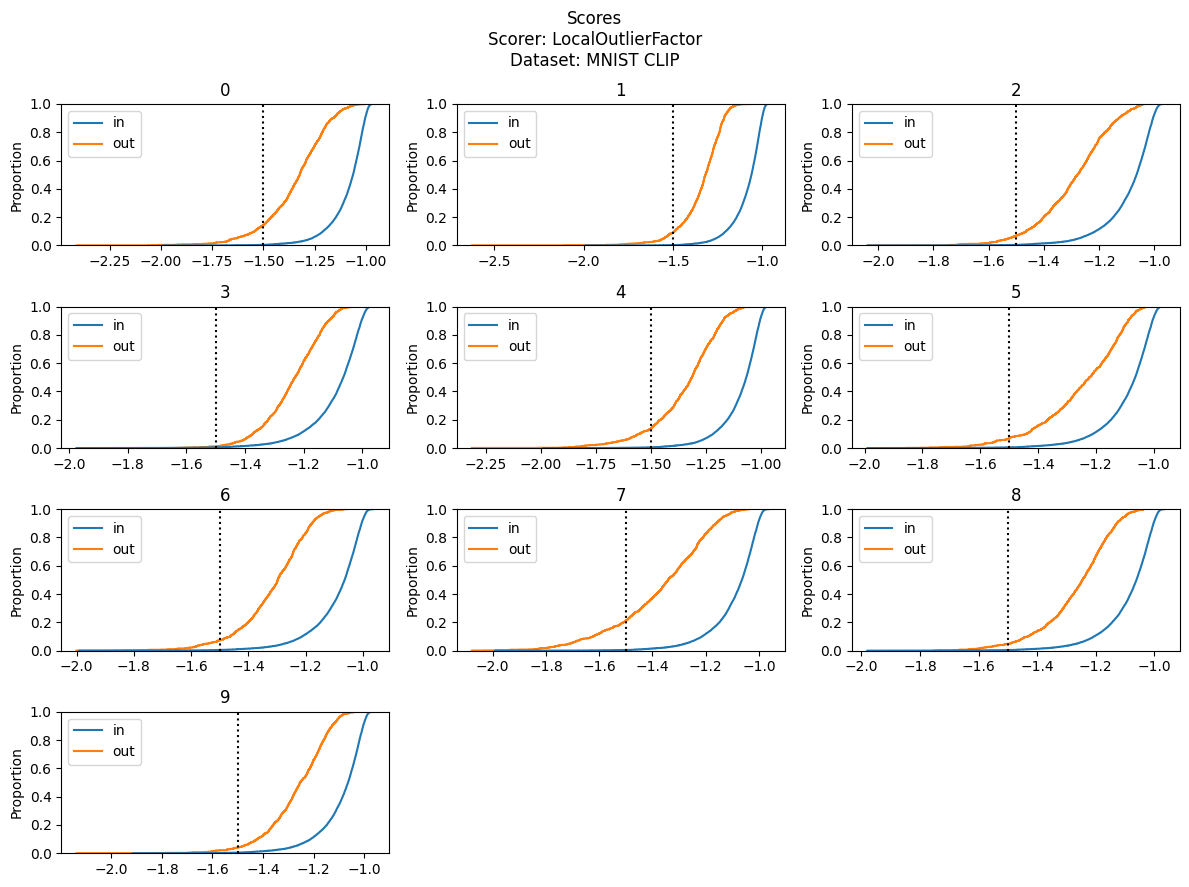

In [18]:
xlim = (np.min(models["scores"].to_list()), np.max(models["scores"].to_list()))
multi_model_plot(models,
                 plot_scores,
                 plot_name="Scores",
                 data_name="MNIST CLIP",
                 kwargs={"xlim": xlim})

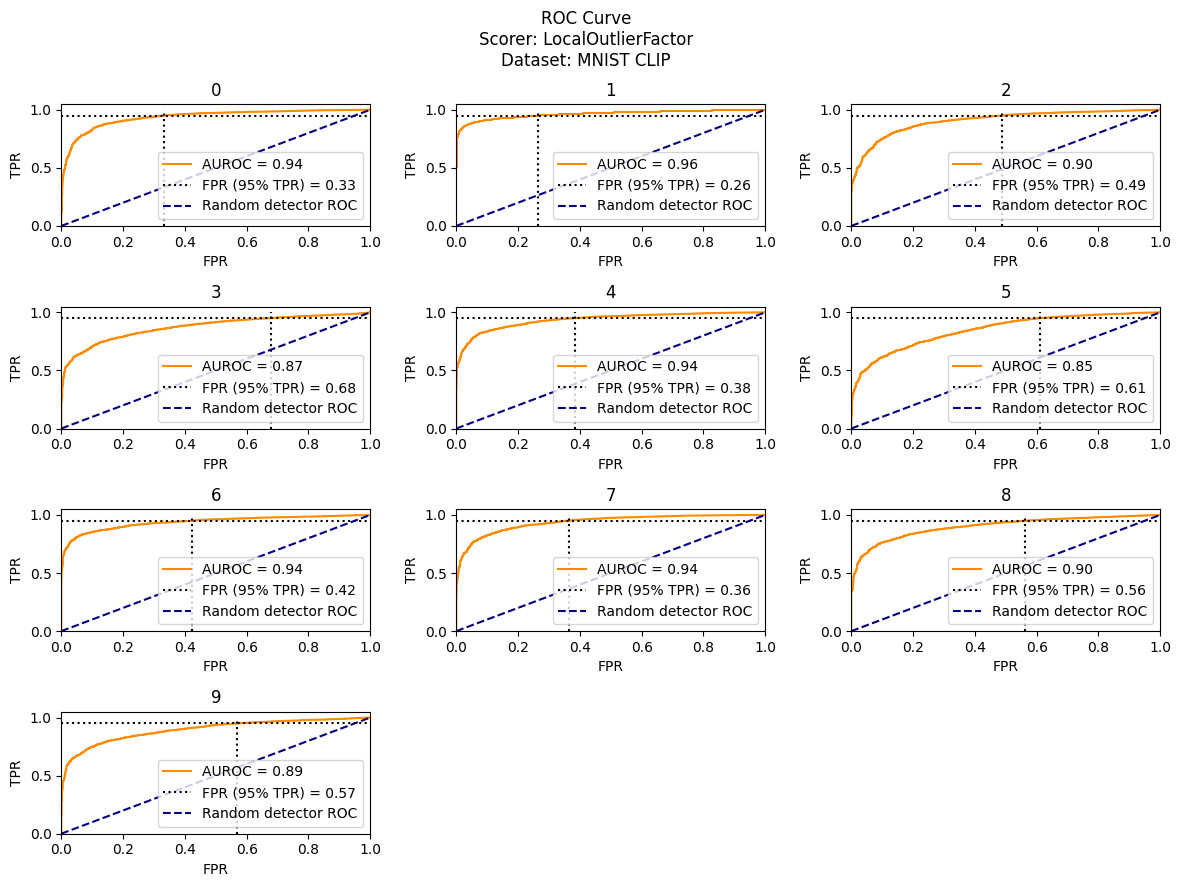

In [19]:
multi_model_plot(models,
                 plot_roc,
                 plot_name="ROC Curve",
                 data_name="MNIST CLIP")

In [20]:
models

,class,scorer,classifier,scores,decision_pred,decision_true,y_pred
0,0,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1,...","[1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, ...","[7, 2, 1, 8, 4, 1, 4, 9, 5, 9, 9, 6, 9, 8, 1, ..."
1,1,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -...","[7, 2, 7, 0, 4, 7, 4, 9, 5, 9, 0, 6, 9, 0, 7, ..."
2,2,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.4558664295340475, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[7, 7, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ..."
3,3,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ..."
4,4,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1...","[7, 2, 1, 0, 9, 1, 2, 9, 5, 9, 0, 6, 9, 0, 1, ..."
5,5,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1,...","[7, 2, 1, 0, 4, 1, 4, 9, 3, 9, 0, 6, 9, 0, 1, ..."
6,6,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1,...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 0, 9, 0, 1, ..."
7,7,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.5210974183668, -1.1256783605807401, -1.009...","[-1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[-1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[9, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ..."
8,8,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ..."
9,9,"LocalOutlierFactor(n_neighbors=15, novelty=True)",KNeighborsClassifier(n_neighbors=15),"[-1.0214984956166597, -1.1256783605807401, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, ...","[7, 2, 1, 0, 4, 1, 4, 8, 5, 7, 0, 6, 4, 0, 1, ..."


## Pets

In [21]:
# df = pd.read_parquet(data_path / "pets" / "pets.parquet")

In [22]:
# df.columns

In [23]:
# label_encoder = LabelEncoder()
# label_encoder.fit(df["species"])
# y_test = label_encoder.transform(df["species"])